<a href="https://colab.research.google.com/github/HWaymentSteele/AF_Cluster/blob/main/AF_cluster_in_colabdesign.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#AF-Cluster, implemented with ColabDesign

Made possible thanks to the [ColabDesign](https://github.com/sokrypton/ColabDesign) codebase!

The DBSCAN clustering step is the same implementation as the code used for Wayment-Steele, Ojoawo, ... Kern (2024) ([ref](https://www.nature.com/articles/s41586-023-06832-9)). This notebook allows for combining that clustering algorithm with all models, recycles, dropout, random seeds.

NB: the results in the paper used min. number of sequences in clusters=3, model 1, and 3 recycles.

H Wayment-Steele, last updated 27 Jul 2025 (add return MSAs of clusters)

In [ ]:
#@title **IMPORTANT:** run this cell first
#@markdown - The latest update to Google Colab broke numpy; this is a temporary patch.
#@markdown - Note after running this cell, the session will crash (this is normal).
import os, numpy, signal
if numpy.__version__ != '1.26.4':
  print(f"Current numpy version {numpy.__version__} is incorrect. Installing 1.26.4...")
  os.system("'pip uninstall -y numpy")
  os.system("pip install numpy==1.26.4")
  # Restart the runtime using os.kill
  os.kill(os. getpid(), signal.SIGKILL)
else:
  print ("Numpy version is correct (1.26.4)")

Current numpy version 2.0.2 is incorrect. Installing 1.26.4...


In [13]:
from posix import truncate
#@title setup
import os, time, gc
if not os.path.isdir("params"):
  # get code
  print("installing ColabDesign")
  os.system("(mkdir params; apt-get install aria2 -qq; \
  aria2c -q -x 16 https://storage.googleapis.com/alphafold/alphafold_params_2022-12-06.tar; \
  tar -xf alphafold_params_2022-12-06.tar -C params; touch params/done.txt )&")

  os.system("pip -q install git+https://github.com/sokrypton/ColabDesign.git@gamma")
  os.system("ln -s /usr/local/lib/python3.*/dist-packages/colabdesign colabdesign")
  os.system("wget https://raw.githubusercontent.com/sokrypton/ColabFold/beta/colabfold/mmseqs/api.py")

  # install hhsuite
  print("installing HHsuite")
  os.makedirs("hhsuite", exist_ok=True)
  os.system(f"curl -fsSL https://github.com/soedinglab/hh-suite/releases/download/v3.3.0/hhsuite-3.3.0-SSE2-Linux.tar.gz | tar xz -C hhsuite/")

  # download params
  if not os.path.isfile("params/done.txt"):
    print("downloading AlphaFold params")
    while not os.path.isfile("params/done.txt"):
      time.sleep(5)
if "hhsuite" not in os.environ['PATH']:
  os.environ['PATH'] += ":hhsuite/bin:hhsuite/scripts"

import re, tempfile
from IPython.display import HTML
from google.colab import files
import numpy as np
from colabdesign import mk_af_model, clear_mem
from colabdesign.af.contrib import predict
from colabdesign.shared.protein import _np_rmsd

from api import run_mmseqs2
import matplotlib.pyplot as plt
import string
import numpy as np
from sklearn.cluster import DBSCAN

def run_hhalign(query_sequence, target_sequence, query_a3m=None, target_a3m=None):
  with tempfile.NamedTemporaryFile() as tmp_query, \
  tempfile.NamedTemporaryFile() as tmp_target, \
  tempfile.NamedTemporaryFile() as tmp_alignment:
    if query_a3m is None:
      tmp_query.write(f">Q\n{query_sequence}\n".encode())
      tmp_query.flush()
      query_a3m = tmp_query.name
    if target_a3m is None:
      tmp_target.write(f">T\n{target_sequence}\n".encode())
      tmp_target.flush()
      target_a3m = tmp_target.name
    os.system(f"hhalign -hide_cons -i {query_a3m} -t {target_a3m} -o {tmp_alignment.name}")
    X, start_indices = predict.parse_hhalign_output(tmp_alignment.name)
  return X, start_indices

def run_hhfilter(input, output, id=90, qid=10):
  os.system(f"hhfilter -id {id} -qid {qid} -i {input} -o {output}")

def one_hot(x,cat=None):
  if cat is None: cat = np.max(x)+1
  oh = np.concatenate((np.eye(cat),np.zeros([1,cat])))
  return oh[x]

def load_fasta(fil):
    seqs, IDs =[], []
    with open(fil,'r') as f:
      for lin in f.readlines():
        if lin.startswith('>'):
          IDs.append(lin.strip()[1:])
        else:
          seqs.append(lin.strip())

    assert len(IDs) == len(seqs)
    return IDs, seqs

def sweep_dbscan(msa, deletion_matrix, jobname, verbose=True, seed=42,
                 min_eps=3, max_eps=20, eps_step=0.5,min_samples=5,
                 write_msa_fastas = True, write_query_seq=True):

  '''Input: MSA with shape N, L (N=num sequences, L=length) where chars are integers
  Ouptut: list of MSA clusters. each is shape [M,L] where M is variable, is the length of the new clustered MSA.
  Each cluster MSA has query sequence at start

  write_query_seq=True: Writes query seq at top of each MSA cluster
                        Allows MSA cluster fastas to be used as AF2 inputs
  '''

  N, L = msa.shape
  ohe_msa = one_hot(msa).reshape(N,-1)
  eps_test_vals=np.arange(min_eps, max_eps+eps_step, eps_step)

  rng = np.random.default_rng(seed=seed)  # Create a local random generator
  smaller_split = rng.choice(len(msa), size=int(len(msa)/4))

  test_split = ohe_msa[smaller_split]
  n_clusters=[]
  if verbose:
    print('eps\tnum clusters\tn not clustered')
  for eps in eps_test_vals:
    clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(test_split)
    n_clust = len(set(clustering.labels_))
    n_not_clustered = len(clustering.labels_[np.where(clustering.labels_==-1)])
    if verbose:
       print('%.2f\t%d\t%d' % (eps, n_clust, n_not_clustered))
    n_clusters.append(n_clust)
    if eps>10 and n_clust==1:
        break

  eps_max = eps_test_vals[np.argmax(n_clusters)]
  if verbose: print("eps max:", eps_max)
  clustering = DBSCAN(eps=eps_max, min_samples=min_samples).fit(ohe_msa)
  clusters = [x for x in list(set(clustering.labels_)) if x>=0]
  n_not_clustered = len(clustering.labels_[np.where(clustering.labels_==-1)])
  if verbose:
    print('%d clusters' % len(clusters))
    print('%d seqs not clustered' % n_not_clustered)

  clustered_msas=[]
  clustered_dtxs=[]
  query_seq=msa[0]
  query_dtx = deletion_matrix[0]

  if write_msa_fastas:
    os.makedirs(f'{jobname}/msa_clusters',exist_ok=True)

    ids, seqs = load_fasta(f'{jobname}/msa.a3m')

    for clus_ind in clusters:
      with open(f'{jobname}/msa_clusters/{clus_ind}_seed{seed}.a3m','w') as f:

        if write_query_seq:
            f.write(f'>{ids[0]}\n{seqs[0]}\n')

        for i, val in enumerate(clustering.labels_):
          if val==clus_ind:
            f.write(f'>{ids[i]}\n{seqs[i]}\n')

  for c in clusters:
    cluster_msa = msa[np.where(clustering.labels_==c)]
    cluster_dtx = deletion_matrix[np.where(clustering.labels_==c)]
    cluster_msa = np.concatenate([[query_seq], cluster_msa])
    cluster_dtx = np.concatenate([[query_dtx], cluster_dtx])

    clustered_msas.append(cluster_msa)
    clustered_dtxs.append(cluster_dtx)

  return clustered_msas, clustered_dtxs

def make_msa_arr(msa, query_seq):
    # get dists between each member of msa and query seq
    dist_arr = [1-len(np.where(x- query_seq!=0)[0])/len(query_seq) for x in msa]

    sorted_msa = [msa[x] for x in np.argsort(dist_arr)]
    sorted_dist_arr = [dist_arr[x] for x in np.argsort(dist_arr)]

    plotting_arr = np.zeros([len(msa), len(query_seq)])*np.NaN

    ctr=0
    for dist, msa_seq in list(zip(sorted_dist_arr, sorted_msa)):
        for j, char in enumerate(msa_seq):
          if char!=21:
            plotting_arr[ctr,j] = dist
        ctr+=1

    return plotting_arr

def plot_cluster_msas(list_of_cluster_msas, pad_size=20, figsize=(8,8),dpi=100,sort_by_dist=False):
    query_seq=list_of_cluster_msas[0][0]
    arrs = [make_msa_arr(msa[1:], query_seq) for msa in list(reversed(list_of_cluster_msas))] # exclude 0 since that's the query seq
    mean_cluster_dists = [np.nanmean(x) for x in arrs]

    if sort_by_dist:
        arrs = [arrs[x] for x in np.argsort(mean_cluster_dists)]

    pad = np.zeros([pad_size, len(query_seq)])*np.NaN
    padded_arrs = [np.vstack([x, pad]) for x in arrs]

    plotting_arr = np.vstack(padded_arrs)

    yaxis_size,  xaxis_size= plotting_arr.shape

    plt.figure(figsize=figsize, dpi=dpi)
    plt.imshow(
        plotting_arr,
    interpolation="nearest",
    aspect="auto",
    cmap="rainbow_r",
    vmin=0,
    vmax=1,
    origin="lower",
    extent=(0,xaxis_size, 0, yaxis_size),)

    for x in np.cumsum([len(x) for x in padded_arrs]):
        plt.axhline(x-0.5*pad_size,color='k',linewidth=0.5)

    plt.xlim(0, xaxis_size)
    plt.ylim(-0.5*pad_size, yaxis_size)
    plt.colorbar(label="Sequence identity to query",aspect=2, fraction=0.05)
    plt.xlabel("Positions")
    plt.ylabel("Sequences")

getting unpaired MSA
parsing msas
gathering info
filtering sequences
selecting final sequences


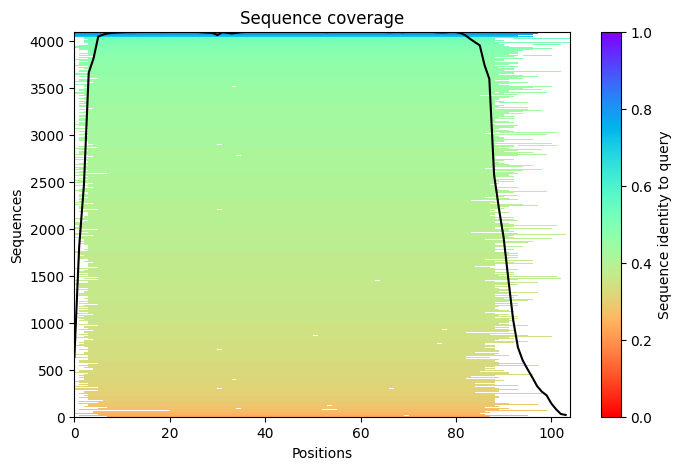

performing AF-Cluster
eps	num clusters	n not clustered
3.00	1	1024
3.50	1	1024
4.00	1	1024
4.50	1	1024
5.00	1	1024
5.50	1	1024
6.00	1	1024
6.50	2	1014
7.00	2	959
7.50	6	766
8.00	4	553
8.50	7	337
9.00	5	173
9.50	2	73
10.00	2	35
10.50	2	1
11.00	2	1
11.50	1	0
eps max: 8.5
9 clusters
676 seqs not clustered
GC 11218


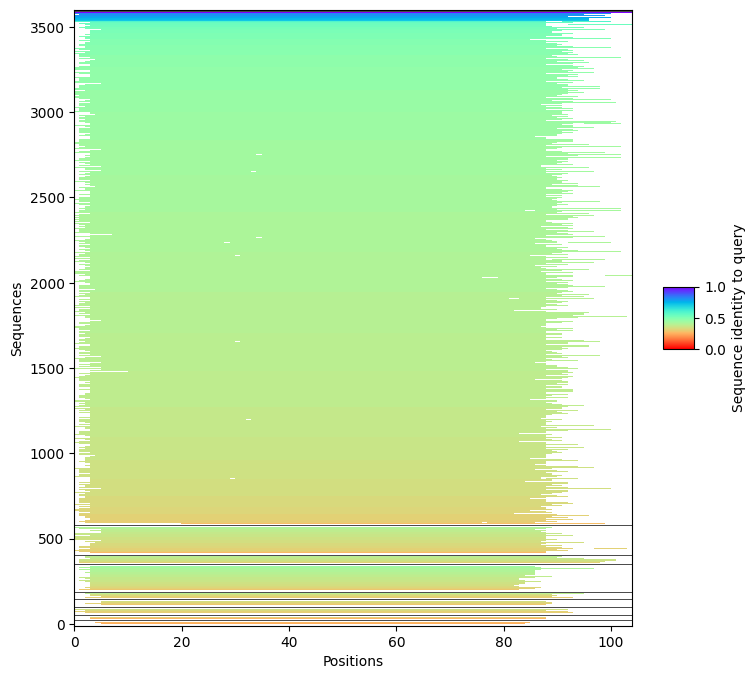

In [17]:
#@title prep_inputs
sequence = "RKTYVLKLYVAGNTPNSVRALKTLNNILEKEFKGVYALKVIDVLKNPQLAEEDKILATPTLAKVLPPPVRRIIGDLSNREKVLIGLDLLYEEIGDQAEDDLGLE" #@param {type:"string"}
jobname = "KaiBTE" #@param {type:"string"}

copies = 1 #@param ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12"] {type:"raw"}
#@markdown ----
#@markdown **MSA options**
msa_method = "mmseqs2" #@param ["mmseqs2","single_sequence","custom_a3m"]
pair_mode = "unpaired_paired" #@param ["unpaired_paired","paired","unpaired"] {type:"string"}
#@markdown filtering options
cov = 75 #@param ["0", "25", "50", "75", "90", "99"] {type:"raw"}
id = 90 #@param ["80","90", "100"] {type:"raw"}
qid = 0 #@param ["0", "10", "15", "20", "30"] {type:"raw"}
do_not_filter = False #@param {type:"boolean"}

#@markdown **AF-Cluster options**
min_samples_in_cluster = 10 #@param ["3","5","10"] {type:"raw"}
dbscan_seed = 1 #@param {type:"raw"}


#@markdown ----
#@markdown **Templates options**
template_mode = "none" #@param ["none", "mmseqs2", "custom"] {type:"string"}
use_templates = template_mode in ["mmseqs2","custom"]
pdb = "" #@param {type:"string"}
chain = "" #@param {type:"string"}
flexible = False #@param {type:"boolean"}
propagate_to_copies = True #@param {type:"boolean"}
rm_interchain = False
rm_sidechain = rm_sequence = flexible

# filter options
sequence = str(sequence).replace("/",":")
sequence = re.sub("[^A-Z:/]", "", sequence.upper())
sequence = re.sub(":+",":",sequence)
sequence = re.sub("^[:/]+","",sequence)
sequence = re.sub("[:/]+$","",sequence)
jobname = re.sub(r'\W+', '', jobname)

# process sequence
sequences = sequence.split(":")
u_sequences = predict.get_unique_sequences(sequences)
if len(sequences) > len(u_sequences):
  print("WARNING: use copies to define homooligomers")
u_lengths = [len(s) for s in u_sequences]

sub_seq = "".join(u_sequences)
seq = sub_seq * copies

jobname = f"{jobname}_{predict.get_hash(seq)[:5]}"
input_opts = {"sequence":u_sequences,
              "copies":copies,
              "msa_method":msa_method,
              "pair_mode":pair_mode,
              "do_not_filter":do_not_filter,
              "cov":cov,
              "id":id,
              "template_mode":template_mode,
              "propagate_to_copies":propagate_to_copies}

##################
# GET MSA
##################
os.makedirs(jobname, exist_ok=True)
if msa_method == "mmseqs2":
  msa, deletion_matrix = predict.get_msa(u_sequences, jobname,
    mode=pair_mode,
    cov=cov, id=id, qid=qid, max_msa=4096,
    do_not_filter=do_not_filter,
    mmseqs2_fn=run_mmseqs2,
    hhfilter_fn=run_hhfilter)

elif msa_method == "single_sequence":
  with open(f"{jobname}/msa.a3m","w") as a3m:
    a3m.write(f">{jobname}\n{sub_seq}\n")
  msa, deletion_matrix = predict.parse_a3m(f"{jobname}/msa.a3m")

elif msa_method == "custom_a3m":
  print("upload custom a3m")
  msa_dict = files.upload()
  lines = msa_dict[list(msa_dict.keys())[0]].decode().splitlines()
  a3m_lines = []
  for line in lines:
    line = line.replace("\x00","")
    if len(line) > 0 and not line.startswith('#'):
      a3m_lines.append(line)

  with open(f"{jobname}/msa.a3m","w") as a3m:
    a3m.write("\n".join(a3m_lines))
  if do_not_filter:
    os.system(f"hhfilter -M first -qid 0 -id 100 -cov 0 -i {jobname}/msa.a3m -o {jobname}/msa.filt.a3m")
  else:
    os.system(f"hhfilter -M first -qid {qid} -id {id} -cov {cov} -i {jobname}/msa.a3m -o {jobname}/msa.filt.a3m")
  msa, deletion_matrix = predict.parse_a3m(f"{jobname}/msa.filt.a3m")

if len(msa) > 1:
  predict.plot_msa(msa, u_lengths).show()

print('performing AF-Cluster')

clustered_msas, clustered_dtxs = sweep_dbscan(msa,deletion_matrix, jobname, verbose=True, seed=dbscan_seed, min_samples=min_samples_in_cluster)
plot_cluster_msas(clustered_msas)

##################
if use_templates:
  print("aligning template")
  template_msa = f"{jobname}/msa.a3m"
  if template_mode == "mmseqs2":
    predict.get_msa(u_sequences, jobname,
      mode="unpaired",
      mmseqs2_fn=run_mmseqs2,
      do_not_filter=True,
      do_not_return=True,
      output_a3m=f"{jobname}/msa_tmp.a3m")
    template_msa = f"{jobname}/msa_tmp.a3m"
    if not propagate_to_copies and copies > 1:
      new_msa = []
      with open(template_msa, "r") as handle:
        for line in handle:
          if not line.startswith(">"):
            new_msa.append(line.rstrip())
      with open(template_msa, "w") as handle:
        for n,seq in enumerate(new_msa):
          handle.write(f">{n}\n{seq*copies}\n")

    templates = {}
    print("ID\tpdb\tcid\tevalue")
    for line in open(f"{jobname}/msa/_env/pdb70.m8","r"):
      p = line.rstrip().split()
      M,target_id,qid,e_value = p[0],p[1],p[2],p[10]
      M = int(M)
      if M not in templates:
        templates[M] = []
      if len(templates[M]) < 4:
        print(f"{int(M)}\t{target_id}\t{qid}\t{e_value}")
        templates[M].append(target_id)
    if len(templates) == 0:
      use_templates = False
      print("ERROR: no templates found...")
    else:
      Ms = sorted(list(templates.keys()))
      pdbs,chains = [],[]
      for M in Ms:
        for n,target_id in enumerate(templates[M]):
          pdb_id,chain_id = target_id.split("_")
          if len(pdbs) < n+1:
            pdbs.append([])
            chains.append([])
          pdbs[n].append(pdb_id)
          chains[n].append(chain_id)
      print(pdbs)
  else:
    pdbs,chains = [pdb],[chain]

if use_templates:
  input_opts.update({"pdbs":pdbs, "chains":chains})
  batches = []
  for pdb,chain in zip(pdbs,chains):
    query_seq = "".join(u_sequences)
    batch = predict.get_template_feats(pdb, chain,
      query_seq=query_seq,
      query_a3m=template_msa,
      copies=copies,
      propagate_to_copies=propagate_to_copies,
      use_seq=not rm_sequence,
      get_pdb_fn=get_pdb,
      align_fn=run_hhalign)
    batches.append(batch)

  # for display
  plt.figure(figsize=(3*len(batches),3))
  for n,batch in enumerate(batches):
    plt.subplot(1,len(batches),n+1)
    plt.title(f"template features {n+1}")
    dgram = batch["dgram"].argmax(-1).astype(float)
    dgram[batch["dgram"].sum(-1) == 0] = np.nan
    Ln = dgram.shape[0]
    plt.imshow(dgram, extent=(0, Ln, Ln, 0))
    predict.plot_ticks(u_lengths * copies)
  plt.show()
else:
  batches = [None]

################
print("GC",gc.collect())

In [ ]:
%%time
#@title run_prediction
#@markdown Model options
model_type = "auto" #@param ["monomer (ptm)", "multimer (v3)", "auto"]
model = "all" #@param ["1", "2", "3", "4", "5", "all"]
num_recycles = 3 #@param ["0", "1", "2", "3", "6", "12", "24"] {type:"raw"}
recycle_early_stop_tolerance = 0.5 #@param ["0.0", "0.5", "1.0"] {type:"raw"}
use_initial_guess = False
#@markdown MSA options
num_msa = 512 #@param ["1","2","4","8","16","32", "64", "128", "256", "512"] {type:"raw"}
num_extra_msa = 1024 #@param ["1","2","4","8","16","32", "64", "128", "256", "512", "1024","2048","4096"] {type:"raw"}
use_cluster_profile = False #@param {type:"boolean"}
use_mlm = False #@param {type:"boolean"}
#@markdown Stochastic options
use_dropout = False #@param {type:"boolean"}
seed = 0 #@param {type:"raw"}
num_seeds = 1 #@param ["1", "2", "4", "8", "16", "32", "64", "128"] {type:"raw"}

if model_type == "monomer (ptm)":
  use_multimer = False
elif model_type == "multimer (v3)":
  use_multimer = True
elif len(u_lengths) > 1 or copies > 1:
  use_multimer = True
else:
  use_multimer = False

model_opts = {"num_msa":num_msa, # number of sequences to use
              "num_extra_msa":num_extra_msa,
              "num_templates":len(batches),
              "use_mlm":True,
              "use_cluster_profile":use_cluster_profile,
              "use_multimer":use_multimer,
              "use_templates":use_templates,
              "use_batch_as_template":False,
              "use_dgram":True,
              "protocol":"hallucination",
              "best_metric":"pae",
              "optimize_seq":False,
              "debug":False,
              "clear_prev":False}

if "af" in dir():
  if model_opts != model_opts_:
    if model_opts["use_multimer"] == af._args["use_multimer"] \
    or model_opts["use_templates"] == af._args["use_templates"]:
      old_params = dict(zip(af._model_names,
                            af._model_params))
    else:
      print("loading alphafold params")
      old_params = {}
    af = mk_af_model(old_params=old_params,
                     **model_opts)
    model_opts_ = predict.copy_dict(model_opts)
else:
  print("loading alphafold params")
  af = mk_af_model(**model_opts)
  model_opts_ = predict.copy_dict(model_opts)

run_opts = {"seed":seed,
            "use_mlm":use_mlm,
            "use_dropout":use_dropout,
            "num_recycles":num_recycles,
            "model":model,
            "use_initial_guess":use_initial_guess}

af.prep_inputs(u_lengths, copies=copies, seed=seed)
if use_templates:
  af.set_opt(use_initial_guess=use_initial_guess)
  for n,batch in enumerate(batches):
    af.set_template(batch=batch, n=n)
  af.set_opt("template",
             rm_sc=rm_sidechain,
             rm_seq=rm_sequence,
             rm_ic=rm_interchain)
af.set_opt("mlm",
           replace_fraction=0.15 if use_mlm else 0.0)

if model == "all":
  models = af._model_names
else:
  models = [af._model_names[int(model) - 1]]

pdb_path = f"{jobname}/pdb"
os.makedirs(pdb_path, exist_ok=True)

seeds = list(range(seed,seed+num_seeds))
print("running prediction")

outputs=[]

for c_ind in range(len(clustered_msas)):
  af.set_msa(clustered_msas[c_ind], clustered_dtxs[c_ind])
  for seed in seeds:
    af.set_seed(seed)
    for model in models:
      o={}
      recycle = 0
      af._inputs.pop("prev",None)
      stop_recycle = False
      while recycle < num_recycles + 1:
        af.predict(dropout=use_dropout, models=[model], verbose=False)

        print_str = f"cluster={c_ind} seed={seed} model={model} recycle={recycle}"
        print_key = ["plddt","ptm"]
        if len(af._lengths) > 1: print_key.append("i_ptm")
        for k in print_key:
          print_str += f" {k}={af.aux['log'][k]:.3f}"

        af._inputs["prev"] = af.aux["prev"]
        af._save_results(save_best=True, verbose=False)
        af._k += 1
        output_pdb = f"{pdb_path}/{model}_cluster{c_ind}_r{recycle}_seed{seed}.pdb"
        af.save_current_pdb(output_pdb)

        recycle += 1
        if recycle > 1:
          rmsd_tol = _np_rmsd(af._tmp["traj"]["xyz"][-2],
                              af._tmp["traj"]["xyz"][-1],
                              use_jax=False)
          if rmsd_tol < recycle_early_stop_tolerance:
            stop_recycle = True
          print_str += f" rmsd_tol={rmsd_tol:.3f}"
        print(print_str)
        if stop_recycle: break
        for k in print_key:
          o.update({k: af.aux['log'][k]})

        o.update({'pdb_path': output_pdb})
        o.update({'model': model})
        o.update({'cluster': c_ind})
        o.update({'cluster_size': clustered_msas[c_ind].shape[0]-1})
        outputs.append(o)

import pandas as pd
outputs = pd.DataFrame.from_records(outputs)
################
print("GC",gc.collect())

loading alphafold params
running prediction
cluster=0 seed=0 model=model_1_ptm recycle=0 plddt=0.576 ptm=0.418
cluster=0 seed=0 model=model_1_ptm recycle=1 plddt=0.583 ptm=0.416 rmsd_tol=3.402
cluster=0 seed=0 model=model_1_ptm recycle=2 plddt=0.570 ptm=0.421 rmsd_tol=1.426
cluster=0 seed=0 model=model_1_ptm recycle=3 plddt=0.593 ptm=0.436 rmsd_tol=1.435
cluster=0 seed=0 model=model_2_ptm recycle=0 plddt=0.631 ptm=0.507
cluster=0 seed=0 model=model_2_ptm recycle=1 plddt=0.611 ptm=0.483 rmsd_tol=2.370
cluster=0 seed=0 model=model_2_ptm recycle=2 plddt=0.612 ptm=0.478 rmsd_tol=2.592
cluster=0 seed=0 model=model_2_ptm recycle=3 plddt=0.590 ptm=0.454 rmsd_tol=1.358
cluster=0 seed=0 model=model_3_ptm recycle=0 plddt=0.621 ptm=0.444
cluster=0 seed=0 model=model_3_ptm recycle=1 plddt=0.596 ptm=0.433 rmsd_tol=4.945
cluster=0 seed=0 model=model_3_ptm recycle=2 plddt=0.592 ptm=0.442 rmsd_tol=1.390
cluster=0 seed=0 model=model_3_ptm recycle=3 plddt=0.609 ptm=0.460 rmsd_tol=2.330
cluster=0 seed=0 

In [ ]:
#@title Setup code to compare to experimental
#@markdown

def get_pdb(pdb_code=""):
  if pdb_code is None or pdb_code == "":
    upload_dict = files.upload()
    pdb_string = upload_dict[list(upload_dict.keys())[0]]
    with open("tmp.pdb","wb") as out: out.write(pdb_string)
    return "tmp.pdb"
  elif os.path.isfile(pdb_code):
    return pdb_code
  elif len(pdb_code) == 4:
    os.makedirs("tmp",exist_ok=True)
    os.system(f"wget -qnc https://files.rcsb.org/download/{pdb_code}.pdb -P tmp/")
    return f"tmp/{pdb_code}.pdb"
  else:
    os.makedirs("tmp",exist_ok=True)
    os.system(f"wget -qnc https://alphafold.ebi.ac.uk/files/AF-{pdb_code}-F1-model_v4.pdb -P tmp/")
    return f"tmp/AF-{pdb_code}-F1-model_v4.pdb"

def get_pdb_and_chain(pdb_code="",chain="A",len=None,offset=None):
  get_pdb(pdb_code)
  from colabdesign.shared.protein import pdb_to_string, renum_pdb_str
  string = pdb_to_string('tmp/{0}.pdb'.format(pdb_code),chains=chain,models=1)
  if offset is not None:
    string = renum_pdb_str(string,[len],offset=offset)
  else:
    string = renum_pdb_str(string,[len])

  with open('tmp/{0}{1}.pdb'.format(pdb_code,chain),'w') as f:
    f.write(string)

if not os.path.exists('TMscore_cpp'):
  os.system('wget https://zhanggroup.org/TM-score/TMscore_cpp.gz')
  os.system('gunzip TMscore_cpp.gz')
  os.system('chmod +x TMscore_cpp')

"""
Compute TM Scores between two PDBs and parse outputs
pdb_pred -- The path to the predicted PDB
pdb_native -- The path to the native PDB
test_len -- run asserts that the input and output should have the same length
"""
import subprocess

tm_re = re.compile(r'TM-score[\s]*=[\s]*(\d.\d+)')
ref_len_re = re.compile(r'Length=[\s]*(\d+)[\s]*\(by which all scores are normalized\)')
common_re = re.compile(r'Number of residues in common=[\s]*(\d+)')
super_re = re.compile(r'\(":" denotes the residue pairs of distance < 5\.0 Angstrom\)\\n([A-Z\-]+)\\n[" ", :]+\\n([A-Z\-]+)\\n')

def compute_tmscore(pdb_pred, pdb_native, test_len=False):
  cmd = (['./TMscore_cpp', pdb_pred, pdb_native])
  tmscore_output = str(subprocess.check_output(cmd))
  try:
    tm_out = float(tm_re.search(tmscore_output).group(1))
    reflen = int(ref_len_re.search(tmscore_output).group(1))
    common = int(common_re.search(tmscore_output).group(1))

    seq1 = super_re.search(tmscore_output).group(1)
    seq2 = super_re.search(tmscore_output).group(1)
  except Exception as e:
    print("Failed on: " + " ".join(cmd))
    raise e

  if test_len:
    assert reflen == common, cmd
    assert seq1 == seq2, cmd
    assert len(seq1) == reflen, cmd

  return tm_out

In [ ]:
get_pdb_and_chain('2QKE',chain='E',len=104)
get_pdb_and_chain('5JYT',chain='A',len=106, offset=-3) # TM-score needs numbering being the same

In [ ]:
def compute_tmscore_(row, native_pdb):
  return compute_tmscore(row['pdb_path'],native_pdb)

outputs['TMscore_2QKEE'] = outputs.apply(lambda row: compute_tmscore_(row, 'tmp/2QKEE.pdb'), axis=1)
outputs['TMscore_5JYTA'] = outputs.apply(lambda row: compute_tmscore_(row, 'tmp/5JYTA.pdb'), axis=1)

In [ ]:
outputs

,plddt,ptm,pdb_path,model,cluster,cluster_size,TMscore_2QKEE,TMscore_5JYTA
0,0.592678,0.435655,KaiBTE_13036/pdb/model_1_ptm_cluster0_r3_seed0...,model_1_ptm,0,52,0.6499,0.4407
1,0.592678,0.435655,KaiBTE_13036/pdb/model_1_ptm_cluster0_r3_seed0...,model_1_ptm,0,52,0.6499,0.4407
2,0.592678,0.435655,KaiBTE_13036/pdb/model_1_ptm_cluster0_r3_seed0...,model_1_ptm,0,52,0.6499,0.4407
3,0.592678,0.435655,KaiBTE_13036/pdb/model_1_ptm_cluster0_r3_seed0...,model_1_ptm,0,52,0.6499,0.4407
4,0.589853,0.453781,KaiBTE_13036/pdb/model_2_ptm_cluster0_r3_seed0...,model_2_ptm,0,52,0.7554,0.4610
...,...,...,...,...,...,...,...,...
368,0.656659,0.552536,KaiBTE_13036/pdb/model_4_ptm_cluster18_r3_seed...,model_4_ptm,18,14,0.4728,0.6835
369,0.782608,0.711065,KaiBTE_13036/pdb/model_5_ptm_cluster18_r3_seed...,model_5_ptm,18,14,0.4694,0.7256
370,0.782608,0.711065,KaiBTE_13036/pdb/model_5_ptm_cluster18_r3_seed...,model_5_ptm,18,14,0.4694,0.7256
371,0.782608,0.711065,KaiBTE_13036/pdb/model_5_ptm_cluster18_r3_seed...,model_5_ptm,18,14,0.4694,0.7256


In [ ]:
import plotly.express as px

# Create a scatter plot with hover labels
fig = px.scatter(outputs, x='TMscore_2QKEE', y='TMscore_5JYTA', color='plddt',
                 color_continuous_scale='rainbow_r',range_color=[0.5,0.9],
                 width=400,height=400, template="simple_white",hover_data=["pdb_path","cluster_size"])

# Show the plot
fig.show()

In [ ]:
#@title Download prediction

#@markdown Once this cell has been executed, a zip-archive with
#@markdown the obtained prediction will be automatically downloaded
#@markdown to your computer.

# add settings file
settings_path = f"{jobname}/settings.txt"
with open(settings_path, "w") as text_file:
  if "input_opts" in dir():
    for k,v in input_opts.items():
      text_file.write(f"{k}={v}\n")
  if "model_opts" in dir():
    for k,v in model_opts.items():
      text_file.write(f"{k}={v}\n")
  if "run_opts" in dir():
    for k,v in run_opts.items():
      text_file.write(f"{k}={v}\n")
# --- Download the predictions ---
os.system(f"zip -r {jobname}.zip {jobname}")
files.download(f'{jobname}.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>